In [1]:
# add additional processes to serve as workers 
n_procs = 3
addprocs(n_procs) 

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
# add present working directory to path from which to load modules
push!(LOAD_PATH, ".") 

# load module DynamicProgramming on each of the processes 
using DynamicProgramming
for p in workers()
    remotecall_fetch(p, eval, :(using DynamicProgramming))
end

In [4]:
## define the dynamic programming problem 

# dynamics 
@everywhere function f(t::Int64, x::Array{Float64, 1}, u::Float64, theta::Array{Float64, 1}) 
    xu = x[1]*(1-u)
    # sensitivity w.r.t. r 
    Df_r = xu*(1 - x[1]*(1-u))
    Df_xt = (1+theta[1])*(1 - u) - 2*theta[1]*(1 - u)^2*x[1]  
    return [xu + theta[1]*xu*(1 - xu); Df_r + Df_xt*x[2]]
end

# nominal parameter value 
@everywhere theta0 = [0.5, 1000.0]
f(0, [1.; 0.], 0.3, theta0)

# time horizon 
@everywhere N = 25

# state dimension 
@everywhere n = 2

# stage reward function 
@everywhere function phi(x::Array{Float64, 1}, u::Float64, theta::Array{Float64, 1})
    if x[1] == 0 
        return 0
    else
        return  x[1]*(1 - u) + (theta[2]/x[1])^2*(1 - u)*x[2]^2 
    end
end

# define state grid 
@everywhere nx1 = 32 # number of grid points in each dimension  
@everywhere nx2 = 32
@everywhere xgrid = (linspace(0, 1, nx1), linspace(-1, 1, nx2)) 

# define input grid 
@everywhere ugrid = 0:0.01:1; 

In [5]:
# time dynamic programming algorithm for a variety of "group_sizes"
exp_max = 10
t = zeros(exp_max + 1)
for i=1:exp_max
    group_size = 2^i
    tic()
    dp(f, phi, ugrid, xgrid, theta0, N, group_size); 
    t[i+1] = toc()
end

elapsed time: 5.159044573 seconds
elapsed time: 2.516851803 seconds
elapsed time: 1.878630144 seconds
elapsed time: 1.543093516 seconds
elapsed time: 1.369226391 seconds
elapsed time: 1.373637289 seconds
elapsed time: 1.325803428 seconds
elapsed time: 1.726659918 seconds
elapsed time: 1.691860611 seconds
elapsed time: 3.280093117 seconds


In [6]:
using Gadfly

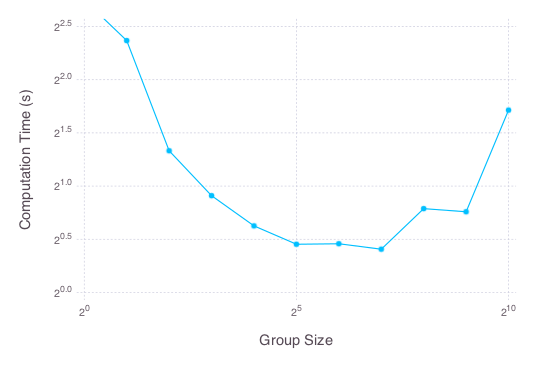

In [7]:
# plot computation time on a log-log scale 
plot(x=2.^collect(0:exp_max), y=t, Scale.x_log2, Scale.y_log2, Guide.XLabel("Group Size"), Guide.YLabel("Computation Time (s)"), Geom.line, Geom.point)